# Неделя 3. Соревнование.
В этом задании вам нужно воспользоваться опытом предыдущих недель, чтобы побить бейзлайн в [соревновании по сентимент-анализу отзывов](https://www.kaggle.com/c/product-reviews-sentiment-analysis-light) на товары на Kaggle Inclass.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve
from random import shuffle
import random

In [2]:
# seed = random.randint(0, 10000)
seed = 8269
seed

8269

## Загрузка и изучение данных

In [3]:
train_data = pd.read_csv(
    "..\..\Data\products_sentiment_train.tsv",
    "\t",
    names=["text", "class"],
    dtype={ "text": "str", "class": "int" })
train_data.head()

,text,class
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [4]:
test_data = pd.read_csv(
    "..\..\Data\products_sentiment_test.tsv",
    "\t",
    index_col="Id",
    dtype={ "text": "str", "Id": "int" })
test_data.head()

,text
Id,
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [5]:
def show_proportion_data(frame, column):
    """ Функция строит гистограмму показывающую насколько сбалансированны классы """
    proportion_plot = frame.plot(
        kind="hist",
        title="Labels proportion",
        figsize=(2,3),
        legend=False)
    proportion_plot.set_xlabel("Label value")
    proportion_plot.set_ylabel("Label frequency")
    negative_count = frame[frame[column] == 0].shape[0]
    positive_count = frame[frame[column] == 1].shape[0]
    negative_proportion = float(negative_count)/float(frame.shape[0])
    positive_proportion = float(positive_count)/float(frame.shape[0])
    print ("Количество отзывов: %i" % (frame.shape[0]))
    print ("Количество позитивных отзывов: %i" % (positive_count))
    print ("Количество негативных отзывов: %i" % (negative_count))
    print ("Разница: %i" % (positive_count - negative_count))
    print ("Доля позитивных отзывов: %.4f%%\nДоля негативных отзывов: %.4f%%\nПозитивных отзывов больше в %.4f раз" % (positive_proportion, negative_proportion, positive_proportion/negative_proportion))
    plt.show()

Количество отзывов: 2000
Количество позитивных отзывов: 1274
Количество негативных отзывов: 726
Разница: 548
Доля позитивных отзывов: 0.6370%
Доля негативных отзывов: 0.3630%
Позитивных отзывов больше в 1.7548 раз


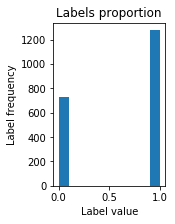

In [6]:
show_proportion_data(train_data, "class")

In [7]:
texts = train_data["text"].tolist()
classes = train_data["class"].tolist()

In [8]:
def score_model_template(
    model_name,
    model_pipe,
    frame,
    frame_columns,
    score_texts,
    score_classes,
    print_results=True
):
    """ Функция принимает на вход модель, данные и фрейм с результатами, возвращает новый фрейм с обновленными результатами. """
    accuracy_scores = cross_val_score(
        model_pipe,
        score_texts,
        score_classes,
        scoring="accuracy")
    roc_auc_scores = cross_val_score(
        model_pipe,
        score_texts,
        score_classes,
        scoring="roc_auc")
    average_accuracy = np.average(accuracy_scores)
    std_accuracy = np.std(accuracy_scores)
    average_roc_auc = np.average(roc_auc_scores)
    std_roc_auc = np.std(roc_auc_scores)
    frame = frame.append(pd.DataFrame([
        [average_accuracy, std_accuracy, average_roc_auc, std_roc_auc]
    ], index=[model_name], columns=frame_columns))
    if(print_results):
        print ("Accuracy:\n\tAverage: {0:.3f}\n\tStandard Deviation: {1:.3f}".format(
            average_accuracy,
            std_accuracy))
        print ("ROC AUC:\n\tAverage: {0:.3f}\n\tStandard Deviation: {1:.3f}".format(
            np.average(roc_auc_scores),
            np.std(roc_auc_scores)))
    return frame

def score_model(
    model_name,
    model_pipe,
    frame,
    frame_columns,
    print_results=True
):
    return score_model_template(
        model_name,
        model_pipe,
        frame,
        frame_columns,
        texts,
        classes,
        print_results)

# Построить ROC AUC кривую
def ROC_AUC_curve(vectorizer_factory, model_factory):
    rate = 0.3
    vectorizer = vectorizer_factory()
    vectorized_texts = vectorizer.fit_transform(texts)
    train_texts, test_texts, train_classes, test_classes = train_test_split(
        vectorized_texts,
        classes,
        test_size=rate,
        random_state=seed,
        stratify=classes
    )
    model = model_factory().fit(train_texts, train_classes)
    probabilities = list(map(lambda pred: pred[1], model.predict_proba(test_texts)))

    fpr, tpr, thr = roc_curve(test_classes, probabilities)
    distance,fpr_v,tpr_v,thr_v = min(zip(np.sqrt((1.-tpr)**2+fpr**2),fpr,tpr,thr), key=lambda d:d[0])

    plt.plot(fpr, tpr, label="ROC AUC curve")
    plt.scatter(fpr_v, tpr_v, color="red")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC AUC")
    return distance

def model_metrics(vectorizer_factory, model_factory):
    vectorizer = vectorizer_factory()
    vectorized_texts = vectorizer.fit_transform(texts)
    full_model = model_factory().fit(vectorized_texts, classes)
    
    distance = ROC_AUC_curve(vectorizer_factory, model_factory)
    
    main_features = list(map(
        lambda feature: feature[0],
        sorted(
            zip(vectorizer.get_feature_names(), np.abs(full_model.coef_[0])),
            key=lambda feature: feature[1],
            reverse=True)[:5]))
    print ("Main features:", main_features)
    return distance

In [9]:
result_columns = ["Accuracy", "Accuracy_std", "ROC_AUC", "ROC_AUC_std"]
results = pd.DataFrame(columns=result_columns)

# Построение и сравнение baseline решений

Строим решения для следующих типов моделей: LogisticRegression, SVM, SGD, Ridge, RandomForest и GradientBoosting.
Для каждого типа модели пробуем три различных векторизатора: Count, TF-IDF и Hashing.

## Logistic regression

### Count Vectorizer

In [10]:
count_logistic_pipe = Pipeline([("vectorize", CountVectorizer()), ("model", LogisticRegression())])
results = score_model(
    "Count Logistic baseline",
    count_logistic_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.774
	Standard Deviation: 0.023
ROC AUC:
	Average: 0.832
	Standard Deviation: 0.020


### TF-IDF Vectorizer

In [11]:
tfidf_logistic_pipe = Pipeline([("vectorize", TfidfVectorizer()), ("model", LogisticRegression())])
results = score_model(
    "Tfidf Logistic",
    tfidf_logistic_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.758
	Standard Deviation: 0.014
ROC AUC:
	Average: 0.847
	Standard Deviation: 0.012


### Hashing Vectorizer

In [12]:
hashing_logistic_pipe = Pipeline([("vectorize", HashingVectorizer()), ("model", LogisticRegression())])
results = score_model(
    "Hashing Logistic",
    hashing_logistic_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.748
	Standard Deviation: 0.015
ROC AUC:
	Average: 0.822
	Standard Deviation: 0.007


Main features: ['great', 'love', 'excellent', 'easy', 'only']


0.346460253459811

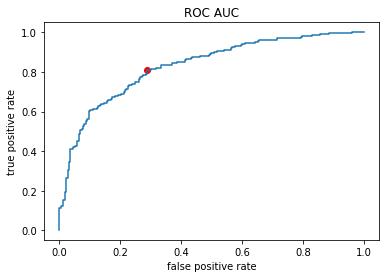

In [13]:
model_metrics(CountVectorizer, LogisticRegression)

## SVM model

### Count Vectorizer

In [14]:
svm_count_pipe = Pipeline([("vectorize", CountVectorizer()), ("model", LinearSVC())])
results = score_model(
    "Count SVM",
    svm_count_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.751
	Standard Deviation: 0.018
ROC AUC:
	Average: 0.807
	Standard Deviation: 0.027


### TF-IDF Vectorizer

In [15]:
svm_tfidf_pipe = Pipeline([("vectorize", TfidfVectorizer()), ("model", LinearSVC())])
results = score_model(
    "TF-IDF SVM",
    svm_tfidf_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.769
	Standard Deviation: 0.013
ROC AUC:
	Average: 0.840
	Standard Deviation: 0.014


### Hashing Vectorizer

In [16]:
svm_hashing_pipe = Pipeline([("vectorize", HashingVectorizer()), ("model", LinearSVC())])
results = score_model(
    "Hashing SVM",
    svm_hashing_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.774
	Standard Deviation: 0.017
ROC AUC:
	Average: 0.839
	Standard Deviation: 0.012


## SGD model

### Count Vectorizer

In [17]:
sgd_count_pipe = Pipeline([("vectorize", CountVectorizer()), ("model", SGDClassifier())])
results = score_model(
    "Count SGD",
    sgd_count_pipe,
    results,
    result_columns
)

C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\sit

Accuracy:
	Average: 0.752
	Standard Deviation: 0.014
ROC AUC:
	Average: 0.788
	Standard Deviation: 0.021


C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\sit

### TF-IDF Vectorizer

In [18]:
sgd_tfidf_pipe = Pipeline([("vectorize", TfidfVectorizer()), ("model", SGDClassifier())])
results = score_model(
    "TF-IDF SGD",
    sgd_tfidf_pipe,
    results,
    result_columns
)

C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\sit

Accuracy:
	Average: 0.752
	Standard Deviation: 0.016
ROC AUC:
	Average: 0.823
	Standard Deviation: 0.017


C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\sit

### Hashing Vectorizer

In [19]:
sgd_hashing_pipe = Pipeline([("vectorize", HashingVectorizer()), ("model", SGDClassifier())])
results = score_model(
    "Hashing SGD",
    sgd_hashing_pipe,
    results,
    result_columns
)

C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\agasp\Anaconda3\lib\sit

Accuracy:
	Average: 0.747
	Standard Deviation: 0.009
ROC AUC:
	Average: 0.821
	Standard Deviation: 0.020


## Ridge regression

### Count Vectorizer

In [20]:
ridge_count_pipe = Pipeline([("vectorize", CountVectorizer()), ("model", RidgeClassifier())])
results = score_model(
    "Count Ridge",
    ridge_count_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.748
	Standard Deviation: 0.013
ROC AUC:
	Average: 0.796
	Standard Deviation: 0.020


### TF-IDF Vectorizer

In [21]:
ridge_tfidf_pipe = Pipeline([("vectorize", TfidfVectorizer()), ("model", RidgeClassifier())])
results = score_model(
    "TF-IDF Ridge",
    ridge_tfidf_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.773
	Standard Deviation: 0.015
ROC AUC:
	Average: 0.843
	Standard Deviation: 0.011


### Hashing Vectorizer

In [22]:
ridge_hashing_pipe = Pipeline([("vectorize", HashingVectorizer()), ("model", RidgeClassifier())])
results = score_model(
    "Hashing Ridge",
    ridge_hashing_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.771
	Standard Deviation: 0.020
ROC AUC:
	Average: 0.839
	Standard Deviation: 0.009


## Random Forest classifier

### Count Vectorizer

In [23]:
random_forest_count_pipe = Pipeline([("vectorize", CountVectorizer()), ("model", RandomForestClassifier())])
results = score_model(
    "Count Random Forest",
    random_forest_count_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.710
	Standard Deviation: 0.003
ROC AUC:
	Average: 0.748
	Standard Deviation: 0.008


### TF-IDF Vectorizer

In [24]:
random_forest_tfidf_pipe = Pipeline([("vectorize", TfidfVectorizer()), ("model", RandomForestClassifier())])
results = score_model(
    "TF-IDF Random Forest",
    random_forest_tfidf_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.721
	Standard Deviation: 0.009
ROC AUC:
	Average: 0.728
	Standard Deviation: 0.010


### Hashing Vectorizer

In [25]:
random_forest_hashing_pipe = Pipeline([("vectorize", HashingVectorizer()), ("model", RandomForestClassifier())])
results = score_model(
    "Hashing Random Forest",
    random_forest_hashing_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.683
	Standard Deviation: 0.010
ROC AUC:
	Average: 0.738
	Standard Deviation: 0.021


## Gradient boosting classifier

### Count Vectorizer

In [26]:
grad_boost_count_pipe = Pipeline([("vectorize", CountVectorizer()), ("model", GradientBoostingClassifier())])
results = score_model(
    "Count Gradient Boosting",
    grad_boost_count_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.735
	Standard Deviation: 0.013
ROC AUC:
	Average: 0.794
	Standard Deviation: 0.014


### TF-IDF Vectorizer

In [27]:
grad_boost_tfidf_pipe = Pipeline([("vectorize", TfidfVectorizer()), ("model", GradientBoostingClassifier())])
results = score_model(
    "TF-IDF Gradient Boosting",
    grad_boost_tfidf_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.717
	Standard Deviation: 0.009
ROC AUC:
	Average: 0.779
	Standard Deviation: 0.008


### Hashing Vectorizer

In [28]:
grad_boost_hashing_pipe = Pipeline([("vectorize", HashingVectorizer()), ("model", GradientBoostingClassifier())])
results = score_model(
    "Hashing Gradient Boosting",
    grad_boost_hashing_pipe,
    results,
    result_columns
)

Accuracy:
	Average: 0.715
	Standard Deviation: 0.003
ROC AUC:
	Average: 0.771
	Standard Deviation: 0.007


# Result

In [29]:
results.sort_values("Accuracy", ascending=False)

,Accuracy,Accuracy_std,ROC_AUC,ROC_AUC_std
Count Logistic baseline,0.774007,0.022582,0.831514,0.020428
Hashing SVM,0.773501,0.017250,0.839114,0.012279
TF-IDF Ridge,0.772501,0.015386,0.842990,0.011041
Hashing Ridge,0.770503,0.020007,0.839136,0.009058
TF-IDF SVM,0.768500,0.012855,0.839591,0.013871
Tfidf Logistic,0.757506,0.014095,0.846948,0.011506
TF-IDF SGD,0.752498,0.015666,0.822666,0.017161
Count SGD,0.751502,0.013725,0.788193,0.020840
Count SVM,0.750508,0.017736,0.807311,0.027137
Hashing Logistic,0.748004,0.014982,0.822183,0.006779


В следующем ноутбуке (week3_peer_logistic) представлено исследование логистической регрессии и финальное решение для этой недели.